In [1]:
# Load Libraries (set the gpu available)
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [2]:
# Prepare Datasets
dataset = 'cifar10'

if dataset == 'cifar10':
    # Load the original CIFAR10 dataset
    # CIFAR10 dataset contains 50000 training images and 10000 test images of 32x32x3 pixels
    # Each image contains a small object such as bird, truck, etc...
    (ds_train, ds_test, ds_val), ds_info = tfds.load('cifar10', split=['train[:80%]', 'test', 'train[80%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
elif dataset == 'imagenette':
    # Imagenette is a subset of 10 easily classified classes from Imagenet
    # (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).
    (ds_train, ds_test, ds_val), ds_info = tfds.load('imagenette/320px-v2', split=['train', 'validation[:50%]', 'validation[50%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
else:
    print('Dataset Error')

print(ds_info.features)
print(ds_info.splits)
print(ds_info.splits['train'].num_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteW8R49G/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteW8R49G/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})
{Split('train'): <SplitInfo num_examples=50000, num_shards=1>, Split('test'): <SplitInfo num_examples=10000, num_shards=1>}
50000


In [3]:
# classify the classes in the dataset
n_channels = ds_info.features['image'].shape[-1]

if dataset == 'imagenette':
    classes = ['tench', 'English springer', 'cassette player', 'chain saw',
               'church', 'French horn', 'garbage truck', 'gas pump',
               'golf ball', 'parachute']
else:
    classes = ds_info.features['label'].names
n_classes = ds_info.features['label'].num_classes
# sort the dataset into trian,valid and test
n_train = len(ds_train)
n_test = len(ds_test)
n_val = len(ds_val)

print(n_train,n_test,n_val)

40000 10000 10000


Image demension: (32, 32, 3) , label: 2


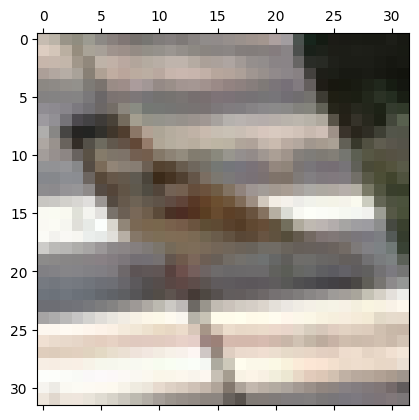

The picture is bird


In [4]:
# Show a Simple Data
idx = np.random.randint(n_train-1)

for element in ds_train.skip(idx).take(1):
    image, label = element

print('Image demension:', image.shape, ', label:',label.numpy())

dimage = tf.reshape(image, image.shape)
plt.matshow(dimage)
plt.show()
print('The picture is', classes[label]) # print the prediction

In [5]:
# Building Input Data pipelines
def tfds_4_NET(image, label):

    image = tf.image.resize((image / 255), [227,227], method='bilinear')  # normalization the image
    label = tf.one_hot(label, n_classes)   # one-hot encoding

    return image, label

In [6]:
n_batch = 64  # set the number of batches
# set the feature maps
dataset = ds_train.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

valiset = ds_val.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
valiset = valiset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

testset = ds_test.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
testset = testset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

In [7]:
# Define the network of AlexNet with Keras Sequential API
import tensorflow as tf

# Define the AlexNet model in TensorFlow/Keras
AlexNet = tf.keras.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)), # convolution2D (1st Conv2D)
    tf.keras.layers.BatchNormalization(), # batch normalization
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),  # max pooling

    # Layer 2
    tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'), # convolution2D (2nd Conv2D)
    tf.keras.layers.BatchNormalization(), # batch normalization
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),  # max pooling

    # Layer 3
    tf.keras.layers.Conv2D(384, (3, 3), padding='same', activation='relu'), # convolution2D (3rd Conv2D)

    # Layer 4
    tf.keras.layers.Conv2D(384, (3, 3), padding='same', activation='relu'), # convolution2D (4th Conv2D)

    # Layer 5
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'), # convolution2D (5th Conv2D)
    tf.keras.layers.BatchNormalization(), # batch normalization
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),  # max pooling

    # Layer 6 (Dense)
    tf.keras.layers.Flatten(),  # flatten
    tf.keras.layers.Dense(4096, activation='relu'), # Dense
    tf.keras.layers.Dropout(0.5), # Dropout

    # Layer 7 (Dense)
    tf.keras.layers.Dense(4096, activation='relu'), # Dense
    tf.keras.layers.Dropout(0.5), # Dropout

    # Layer 8 (Dense)
    tf.keras.layers.Dense(10, activation='softmax')  # 10 output classes
])

# Print model summary
AlexNet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [8]:
# Training the Model
opt = tf.keras.optimizers.Adam(learning_rate=0.001) # optimization function(adam) and learning rate is set to 0.001
AlexNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])  # loss function is categorical_crossentropy

In [9]:
n_epochs = 10 # the number of epochs is 10

# progress the model fitting
results = AlexNet.fit(dataset, epochs=n_epochs, batch_size=n_batch,
                   validation_data=valiset, validation_batch_size=n_batch,
                   verbose=1)

Epoch 1/10
625/625 [==============================] - 78s 103ms/step - loss: 2.3294 - acc: 0.2749 - val_loss: 1.9725 - val_acc: 0.2909
Epoch 2/10
625/625 [==============================] - 63s 101ms/step - loss: 1.6798 - acc: 0.3885 - val_loss: 1.6802 - val_acc: 0.4051
Epoch 3/10
625/625 [==============================] - 63s 100ms/step - loss: 1.5027 - acc: 0.4639 - val_loss: 1.7326 - val_acc: 0.3725
Epoch 4/10
625/625 [==============================] - 63s 101ms/step - loss: 1.3601 - acc: 0.5192 - val_loss: 1.4745 - val_acc: 0.4648
Epoch 5/10
625/625 [==============================] - 63s 101ms/step - loss: 1.2669 - acc: 0.5590 - val_loss: 1.3611 - val_acc: 0.5343
Epoch 6/10
625/625 [==============================] - 62s 99ms/step - loss: 1.1536 - acc: 0.6022 - val_loss: 1.2572 - val_acc: 0.5644
Epoch 7/10
625/625 [==============================] - 62s 100ms/step - loss: 1.0524 - acc: 0.6383 - val_loss: 1.1649 - val_acc: 0.5977
Epoch 8/10
625/625 [==============================] - 62

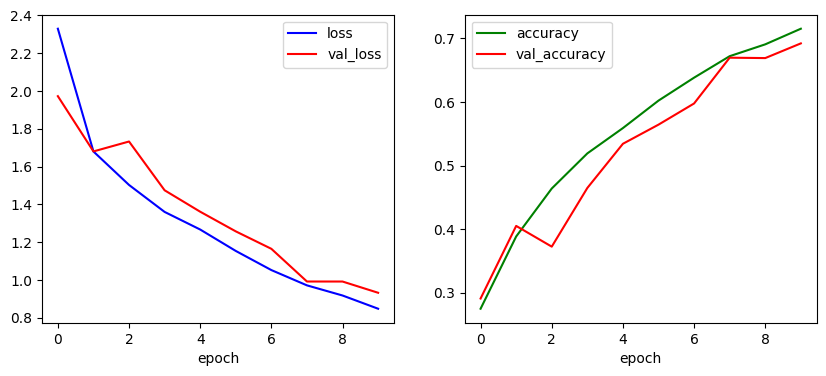

In [10]:
# Plot Convergence Graph and compare the results
# plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(results.history['loss'], 'b-', label='loss')
plt.plot(results.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(results.history['acc'], 'g-', label='accuracy')
plt.plot(results.history['val_acc'], 'r-', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

In [11]:
# Evaluate Model Performance
AlexNet.evaluate(testset)

157/157 [==============================] - 14s 85ms/step - loss: 0.9401 - acc: 0.6901


[0.9401073455810547, 0.6901000142097473]

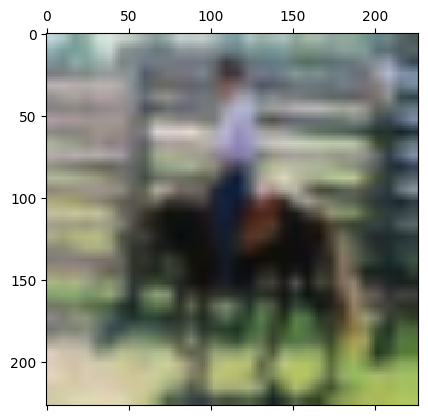

1/1 [==============================] - 0s 418ms/step
My prediction is horse
Actual image is  horse


In [12]:
# Test Model with a Random Sample
idx = np.random.randint(n_test-1)

for element in ds_test.skip(idx).take(1):
    img, lbl = element
    X_test, y_test = tfds_4_NET(img, lbl)

X_test = tf.expand_dims(X_test, axis=0)

dimage = np.array(X_test[0])
plt.matshow(dimage)
plt.show()

outt_4 = AlexNet.predict(X_test)
p_pred = np.argmax(outt_4, axis=-1)

# print the results predicted and actual image
print('My prediction is ' + classes[p_pred[0]])
print('Actual image is  ' + classes[tf.argmax(y_test, -1)])